In [737]:
%matplotlib inline

In [741]:
import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd

## Create test dataset

In [700]:
dataset_length = 100
D = 2
X = np.random.randn(dataset_length,D)*0.1
X[0:dataset_length/2,0] += 0.2
X[0:dataset_length/2,1] += 1
Y = np.ones(dataset_length)
Y[0:dataset_length/2] *= 0

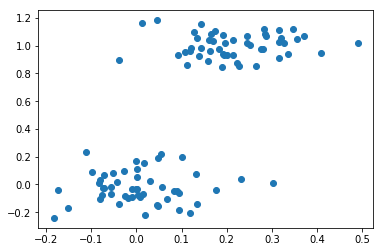

In [701]:
plt.plot(X[:,0],X[:,1],"o")

## Create a Decision Tree trained on this dataset

In [702]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

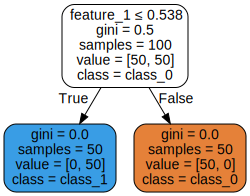

In [703]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["feature_"+str(i) for i in range(D)],  
                         class_names=["class_0", "class_1"],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

### Modify the threshold of the tree
+ The first threshold is splitting the dataset along feature_1 at location 0.51
+ Let us classify the point [0.1, 0.5]

In [704]:
clf.tree_.threshold

array([ 0.54, -2.  , -2.  ])

In [705]:
clf.predict(np.asarray([[0.1,0.5]]))

array([ 1.])

In [706]:
clf.decision_path(np.asarray([[0.1,0.5]])).toarray()

array([[1, 1, 0]])

+ Let us modify the threshold and put it equal to 0
+ Let us classify the same point

In [707]:
clf.tree_.threshold[0] = 0

In [708]:
clf.predict(np.asarray([[0.1,0.5]]))

array([ 0.])

In [709]:
clf.decision_path(np.asarray([[0.1,0.5]])).toarray()

array([[1, 0, 1]])

## Conclusion
Modifying the threshold outside the tree seems to work well :)

## Let us access to important elements from the Decision Tree
the object tree_ keeps the information describing the tree in lists, such that information contained at index $i$ corresponds to the node $i$ of the tree. The root of the tree is labeled 0. we can get the children's indexes using `children_left` or `children_right` arrays

In [710]:
clf.tree_.children_left

array([ 1, -1, -1])

In [711]:
clf.tree_.children_right

array([ 2, -1, -1])

In this case, a leaf is simply a node $\nu_i$ such that `clf.tree_.children_right[i] == -1` and `clf.tree_.children_left[i] ==1`

+ The feature to split on is stored in list `feature`
+ The thresholds in list `threshold`
+ The number of training samples reaching the node are stored in `n_node_samples` 
+ The `decision_path` of the target dataset will be helpfull to re-attribute the instances
+ The `value` list provides the number of elements from each class in the current node

In [712]:
path = clf.decision_path(X[0:3,:])

In [713]:
path.toarray()

array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [714]:
clf.tree_.value[0,:] = [10,10]

In [715]:
clf.tree_.value

array([[[ 10.,  10.]],

       [[  0.,  50.]],

       [[ 50.,   0.]]])

In [716]:
np.set_printoptions(precision=2)

In [717]:
clf.tree_?

# Create the STRUT algorithm step by step

In [782]:
import sklearn
def get_children_distributions(decisiontree,
                               node_index):
    tree = decisiontree.tree_
    child_l = tree.children_left[node_index]
    child_r = tree.children_right[node_index]
    Q_source_l = tree.value[child_l]
    Q_source_r = tree.value[child_r]
    return [np.asarray(Q_source_l), np.asarray(Q_source_r)]
                                              
def get_node_distribution(decisiontree,
                          node_index):
    tree = decisiontree.tree_
    Q = tree.value[node_index]
    return np.asarray(Q)

  
def compute_class_distribution(classes,
                               class_membership):
    unique, counts = np.unique(class_membership, return_counts=True)
    classes_counts = dict(zip(unique, counts))
    classes_index = dict(zip(classes,range(len(classes))))
    distribution = np.zeros(len(classes))
    for label,count in classes_counts.iteritems():
        class_index = classes_index[label]
        distribution[class_index] = count
    return distribution

def KL_divergence(class_counts_P,
                  class_counts_Q):
    # KL Divergence to assess the difference between two distributions
    # Definition: $D_{KL}(P||Q) = \sum{i} P(i)ln(\frac{P(i)}{Q(i)})$
    # epsilon to avoid division by 0
    epsilon = 1e-8
    class_counts_P += epsilon
    class_counts_Q += epsilon
    P = class_counts_P * 1./ class_counts_P.sum()
    Q = class_counts_Q * 1./ class_counts_Q.sum()
    Dkl = (P * np.log(P * 1./ Q)).sum()
    # another possibility is to use scipy.stats.entropy(P,Q) ... but this generates another dependency
    return Dkl

def H(class_counts):
    # Entropy
    # Definition: $H(P) = \sum{i} -P(i) ln(P(i))$
    epsilon = 1e-8
    class_counts += epsilon
    P = class_counts * 1./ class_counts.sum()
    #print "computing H"
    #print "P",class_counts,class_counts.sum()
    #print "H", - (P * np.log(P)).sum()
    return - (P * np.log(P)).sum()

def IG(class_counts_parent,
       class_counts_children):
    # Information Gain
    H_parent = H(class_counts_parent)
    H_children = np.asarray([H(class_counts_child) for class_counts_child in class_counts_children])
    N = class_counts_parent.sum()
    #print "class count parent", class_counts_parent
    #print "class counts IG", class_counts_children
    p_children = np.asarray([class_counts_child.sum()*1./N for class_counts_child in class_counts_children])
    information_gain = H_parent - (p_children * H_children).sum()
    #print "parent H",H_parent
    #print "children H", (p_children * H_children).sum()
    #print "compute information gain",information_gain
    return information_gain
        
def JSD(P,Q):
    M = (P+Q) * 1./2
    #print "M",M,"P",P,"Q",Q
    Dkl_PM = KL_divergence(P,M)
    Dkl_QM = KL_divergence(Q,M)
    #print "Dkl_PM", Dkl_PM, "Dkl_QM", Dkl_QM
    return (Dkl_PM + Dkl_QM) * 1./2

def DG(Q_source_l,
       Q_source_r,
       Q_target_l,
       Q_target_r):
    # compute proportion of instances at left and right
    p_l = Q_target_l.sum() 
    p_r = Q_target_r.sum() 
    total_counts = p_l + p_r
    p_l /= total_counts
    p_r /= total_counts
    #print p_l, p_r, JSD(Q_target_l, Q_source_l), JSD(Q_target_r, Q_source_r)
    # Compute the new distributions at right and left children
   
    # compute the DG
    return 1. - p_l * JSD(Q_target_l, Q_source_l) - p_r * JSD(Q_target_r, Q_source_r)

def compute_Q_children_target(X_target_node,
                              Y_target_node,
                              phi,
                              threshold,
                              classes):
    # Split parent node target sample using the threshold provided
    # instances <= threshold go to the left 
    # instances > threshold go to the right 
    decision_l = X_target_node[:,phi] <= threshold
    decision_r = np.logical_not(decision_l)
    Y_target_child_l = Y_target_node[decision_l]
    Y_target_child_r = Y_target_node[decision_r]
    Q_target_l = compute_class_distribution(classes, Y_target_child_l)
    Q_target_r = compute_class_distribution(classes, Y_target_child_r) 
    return Q_target_l,Q_target_r


def threshold_selection(Q_source_parent,
                        Q_source_l,
                        Q_source_r,
                        X_target_node,
                        Y_target_node,
                        phi,
                        classes):
    # sort the corrdinates of X along phi
    X_phi_sorted = np.sort(X_target_node[:,phi])
    #print X_phi_sorted
    nb_tested_thresholds = X_target_node.shape[0] - 1
    measures_IG = np.zeros(nb_tested_thresholds)
    measures_DG = np.zeros(nb_tested_thresholds)
    for i in xrange(nb_tested_thresholds):
        threshold = (X_phi_sorted[i] + X_phi_sorted[i+1]) * 1./2
        Q_target_l,Q_target_r = compute_Q_children_target(X_target_node,
                                                          Y_target_node,
                                                          phi,
                                                          threshold,
                                                          classes)
        
        
        measures_IG[i] = IG(Q_source_parent,
                            [Q_target_l,Q_target_r])
        measures_DG[i] = DG(Q_source_l,
                            Q_source_r,
                            Q_target_l,
                            Q_target_r)
    index = 0
    for i in xrange(1,nb_tested_thresholds-1):
        if measures_IG[i] >= measures_IG[i-1] and measures_IG[i] >= measures_IG[i+1] and measures_DG[i] > measures_DG[index]:
            index = i
    #print "index",index
    #print "IG",measures_IG
    #print "DG", measures_DG
    threshold = (X_phi_sorted[index] + X_phi_sorted[index+1]) * 1./2
    return threshold

def prune_subtree(decisiontree,
                  node_index):
    tree = decisiontree.tree_
    if tree.children_left[node_index] != -1:
        prune_subtree(decisiontree,
                      tree.children_left[node_index])
        tree.children_left[node_index] = -1
    if tree.children_right[node_index] != -1:
        prune_subtree(decisiontree,
                      tree.children_right[node_index])
        tree.children_right[node_index] = -1

def GINI(class_distribution):
    p = class_distribution / class_distribution.sum()
    return 1 - (p**2).sum()
        
def STRUT(decisiontree,
          node_index,
          X_target_node,
          Y_target_node):
    tree = decisiontree.tree_
    phi = tree.feature[node_index]
    classes = decisiontree.classes_
    threshold = tree.threshold[node_index]
    current_class_distribution = compute_class_distribution(classes,Y_target_node)
    tree.weighted_n_node_samples[node_index] = Y_target_node.size
    tree.value[node_index] = current_class_distribution
    tree.impurity[node_index] = GINI(current_class_distribution)
    print " "
    print "STRUT: node", node_index, "phi: ", phi ,"child left:", tree.children_left[node_index],"child right:", tree.children_right[node_index]
    print "distribution:", current_class_distribution
    tree.n_node_samples[node_index] = Y_target_node.size

    # Unreachable node
    if current_class_distribution.sum() == 0 :
        # Prune unreachable subtree
        print "unreachable node",node_index
        prune_subtree(decisiontree,
                      node_index)
        tree.children_left[tree.children_left == node_index] = -1
        tree.children_right[tree.children_left == node_index] = -1
        tree.children_left[tree.children_right == node_index] = -1
        tree.children_right[tree.children_right == node_index] = -1
        tree.feature[tree.children_left == node_index] = -2
        tree.feature[tree.children_right == node_index] = -2
        tree.feature[node_index] = -2
        return 0

    
    # If it is a leaf one, exit
    if tree.children_left[node_index] == -1 and tree.children_right[node_index] == -1:
        # Here we need to update the information of the leaf
        print "old leaf"
        return 0
    
    
    # Only one class is present in the node
    if (current_class_distribution > 0).sum() == 1 :
        # Prune unreachable subtree
        print "new leaf",tree.children_left[node_index] , tree.children_right[node_index] 
        prune_subtree(decisiontree,
                      node_index)
        tree.feature[node_index] = -2
        if Y_target_node.size >0:
            print "!!!!!!"
            #tree.value[node_index] = np.asarray([compute_class_distribution(classes,Y_target_node)])
        return 0
    
    #tree.value[node_index] = compute_class_distribution(classes,Y_target_node)
    if type(threshold) is np.float64:
        # update threshold  
        print "changing threshold", "node=", node_index, "feature=", phi, "threshold=", threshold
        Q_source_l,Q_source_r = get_children_distributions(decisiontree,
                                                           node_index)
        Q_source_parent = get_node_distribution(decisiontree,
                                                node_index)
        #print "left_child_distrib=",Q_source_l,tree.children_left[node_index]
        #print "right child distrib", Q_source_r,tree.children_right[node_index]
        t1 = threshold_selection(Q_source_parent,
                                 Q_source_l,
                                 Q_source_r,
                                 X_target_node,
                                 Y_target_node,
                                 phi,
                                 classes)
        Q_target_l,Q_target_r = compute_Q_children_target(X_target_node,
                                                          Y_target_node,
                                                          phi,
                                                          t1,
                                                          classes)
        DG_t1 = DG(Q_source_l,
                   Q_source_r,
                   Q_target_l,
                   Q_target_r)
        print "threshold selected 1", t1, "DG ",DG_t1
        t2 = threshold_selection(Q_source_parent,
                                 Q_source_r,
                                 Q_source_l,
                                 X_target_node,
                                 Y_target_node,
                                 phi,
                                 classes)
        Q_target_l,Q_target_r = compute_Q_children_target(X_target_node,
                                                          Y_target_node,
                                                          phi,
                                                          t2,
                                                          classes)
        DG_t2 = DG(Q_source_r,
                   Q_source_l,
                   Q_target_l,
                   Q_target_r)
        print "threshold selected 2", t1, "DG ",DG_t1
        if DG_t1 >= DG_t2:
            tree.threshold[node_index] = t1
        else:
            tree.threshold[node_index] = t2
            # swap children
            old_child_r_id = tree.children_right[node_index]
            tree.children_right[node_index] = tree.children_left[node_index]
            tree.children_left[node_index] = old_child_r_id
    ###### beware it may not work for not numerical data
    
    if tree.children_left[node_index] != -1:
        threshold = tree.threshold[node_index]
        index_X_child_l = X_target_node[:,phi] <= threshold
        X_target_child_l = X_target_node[index_X_child_l,:]
        Y_target_child_l = Y_target_node[index_X_child_l]
        STRUT(decisiontree,
              tree.children_left[node_index],
              X_target_child_l,
              Y_target_child_l)        
                
    if tree.children_right[node_index] != -1:
        threshold = tree.threshold[node_index]
        index_X_child_r = X_target_node[:,phi] > threshold
        X_target_child_r = X_target_node[index_X_child_r,:]
        Y_target_child_r = Y_target_node[index_X_child_r]
        STRUT(decisiontree,
              tree.children_right[node_index],
              X_target_child_r,
              Y_target_child_r)


# Read the dataset

In [783]:
"""
dataset_length = 100
D = 2
X = np.random.randn(dataset_length,D)*0.1
X[0:dataset_length/2,0] += 0.1
X[0:dataset_length/2,0] += 0.2
Y = np.ones(dataset_length)
Y[0:dataset_length/2] *= 0
"""
df = pd.read_csv("data/letter/letter-recognition.data.txt", sep=',', header=None)
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
label = {letter: i for i, letter in enumerate(letters)}
df.iloc[:, 0] = [label[l] for l in df.iloc[:, 0]]
X_source = df[df[9]<np.median(df[9])]
y_source = X_source[0]
X_source = X_source[range(1,len(X_source.columns))]
X_target = df[df[9]>=np.median(df[9])]
X_target_005 = X_target.iloc[0: int(X_target.shape[0]*0.05),X_source.columns]
y_target_005 = X_target.iloc[0: int(X_target.shape[0]*0.05), 0]
X_target_095 = X_target.iloc[int(X_target.shape[0]*0.05):,X_source.columns]
y_target_095 = X_target.iloc[int(X_target.shape[0]*0.05):, 0]

In [784]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_source, y_source)

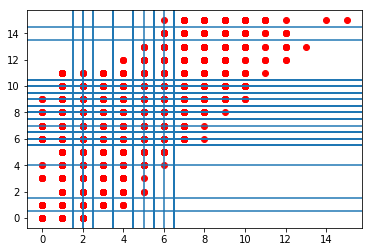

In [785]:
plt.plot(X_source[1],X_source[2],"ro")
for node,feature in enumerate(clf.tree_.feature):
    if feature ==0:
        plt.axvline(x = clf.tree_.threshold[node])
    elif feature == 1:
        plt.axhline(y = clf.tree_.threshold[node])
        

In [771]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["feature_"+str(i) for i in X_source.columns],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

In [786]:
clf.score(X_target_005,y_target_005)

0.28547854785478549

In [787]:
STRUT(clf,
      0,
      X_target_005.values,
      y_target_005.values)

 
STRUT: node 0 phi:  10 child left: 1 child right: 60
distribution: [  1.  42.  26.  40.  31.  20.  21.  24.  24.  34.  28.  31.  22.  13.  18.
  11.  10.  21.  45.  35.  30.   5.   2.  28.  17.  27.]
changing threshold node= 0 feature= 10 threshold= 2.5
threshold selected 1 0.0 DG  0.679387507381
threshold selected 2 0.0 DG  0.679387507381
 
STRUT: node 60 phi:  11 child left: 61 child right: 122
distribution: [  1.  42.  26.  40.  31.  20.  21.  24.  24.  34.  28.  31.  22.  13.  18.
  11.  10.  21.  45.  35.  28.   5.   2.  28.  17.  27.]
changing threshold node= 60 feature= 11 threshold= 4.5
threshold selected 1 2.5 DG  0.707652745523
threshold selected 2 2.5 DG  0.707652745523
 
STRUT: node 61 phi:  13 child left: 62 child right: 81
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
new leaf 62 81
!!!!!!
 
STRUT: node 122 phi:  10 child left: 123 child right: 1552
distribution: [  1.  42.  26.  40.  31.  20.  2

threshold selected 2 0.0 DG  0.728737413827
 
STRUT: node 270 phi:  13 child left: 271 child right: 272
distribution: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.]
changing threshold node= 270 feature= 13 threshold= 7.5
threshold selected 1 8.0 DG  0.135649518396
threshold selected 2 8.0 DG  0.135649518396
 
STRUT: node 272 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.]
old leaf
 
STRUT: node 271 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
unreachable node 271
 
STRUT: node 273 phi:  6 child left: 274 child right: 303
distribution: [  1.  35.  23.  21.  19.  14.  21.  20.  17.  11.  21.  16.   7.   9.  17.
  10.   5.  13.  36.  19.  16.   3.   0.  19.   5.  23.]
changing threshold node= 273 feature=

/Library/Python/2.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in divide


threshold selected 2 8.5 DG  0.611120234981
 
STRUT: node 274 phi:  9 child left: 275 child right: 298
distribution: [  1.  33.  19.  21.  18.   1.  21.  18.  16.   7.  20.  16.   6.   4.  17.
   3.   5.  12.  34.   5.  13.   1.   0.  18.   2.  22.]
changing threshold node= 274 feature= 9 threshold= 7.5
threshold selected 1 11.5 DG  0.5391151574
threshold selected 2 11.5 DG  0.5391151574
 
STRUT: node 275 phi:  14 child left: 276 child right: 287
distribution: [  1.  33.  17.  21.  18.   1.  21.  18.   8.   4.  20.  15.   6.   4.  17.
   3.   5.  12.  34.   5.  13.   1.   0.  18.   2.  18.]
changing threshold node= 275 feature= 14 threshold= 4.5
threshold selected 1 1.0 DG  0.471596598214
threshold selected 2 1.0 DG  0.471596598214
 
STRUT: node 276 phi:  6 child left: 277 child right: 286
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  0.  3.  0.  0.  0.  0.  0.]
changing threshold node= 276 feature= 6 threshold= 6.5
threshold selected 1 6.

STRUT: node 317 phi:  13 child left: 318 child right: 329
distribution: [  0.   2.   4.   0.   1.   9.   0.   0.   0.   2.   1.   0.   0.   1.   0.
   2.   0.   0.   1.  14.   2.   0.   0.   1.   3.   1.]
changing threshold node= 317 feature= 13 threshold= 8.5
threshold selected 1 7.0 DG  0.601186620976
threshold selected 2 7.0 DG  0.601186620976
 
STRUT: node 329 phi:  15 child left: 330 child right: 333
distribution: [  0.   2.   4.   0.   1.   9.   0.   0.   0.   2.   1.   0.   0.   1.   0.
   2.   0.   0.   1.  10.   2.   0.   0.   1.   3.   1.]
changing threshold node= 329 feature= 15 threshold= 4.5
threshold selected 1 5.5 DG  0.582326716545
threshold selected 2 5.5 DG  0.582326716545
 
STRUT: node 330 phi:  11 child left: 331 child right: 332
distribution: [ 0.  0.  0.  0.  1.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  9.  0.  0.  0.  1.  3.  1.]
changing threshold node= 330 feature= 11 threshold= 5.5
threshold selected 1 7.5 DG  0.364237350491
threshold selected 

STRUT: node 370 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  0.  0.  0.  0.  0.  0.  0.  0.]
old leaf
 
STRUT: node 365 phi:  8 child left: 366 child right: 367
distribution: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.]
changing threshold node= 365 feature= 8 threshold= 2.5
threshold selected 1 5.5 DG  0.372259753146
threshold selected 2 5.5 DG  0.372259753146
 
STRUT: node 366 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
old leaf
 
STRUT: node 367 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.]
old leaf
 
STRUT: node 371 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0

STRUT: node 425 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.]
old leaf
 
STRUT: node 420 phi:  6 child left: 421 child right: 422
distribution: [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
changing threshold node= 420 feature= 6 threshold= 10.5
threshold selected 1 7.0 DG  -0.13096376752
threshold selected 2 7.0 DG  -0.13096376752
 
STRUT: node 422 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
old leaf
 
STRUT: node 421 phi:  -2 child left: -1 child right: -1
distribution: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
old leaf
 
STRUT: node 444 phi:  14 child left: 445 child right: 468
distribution: [ 0.  0.  3.  0.  4.  0.  0.  0.  0.  0.

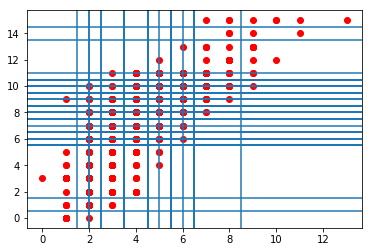

In [788]:
plt.plot(X_target_005[1],X_target_005[2],"ro")
for node,feature in enumerate(clf.tree_.feature):
    if feature ==0:
        plt.axvline(x = clf.tree_.threshold[node])
    elif feature == 1:
        plt.axhline(y = clf.tree_.threshold[node])
        

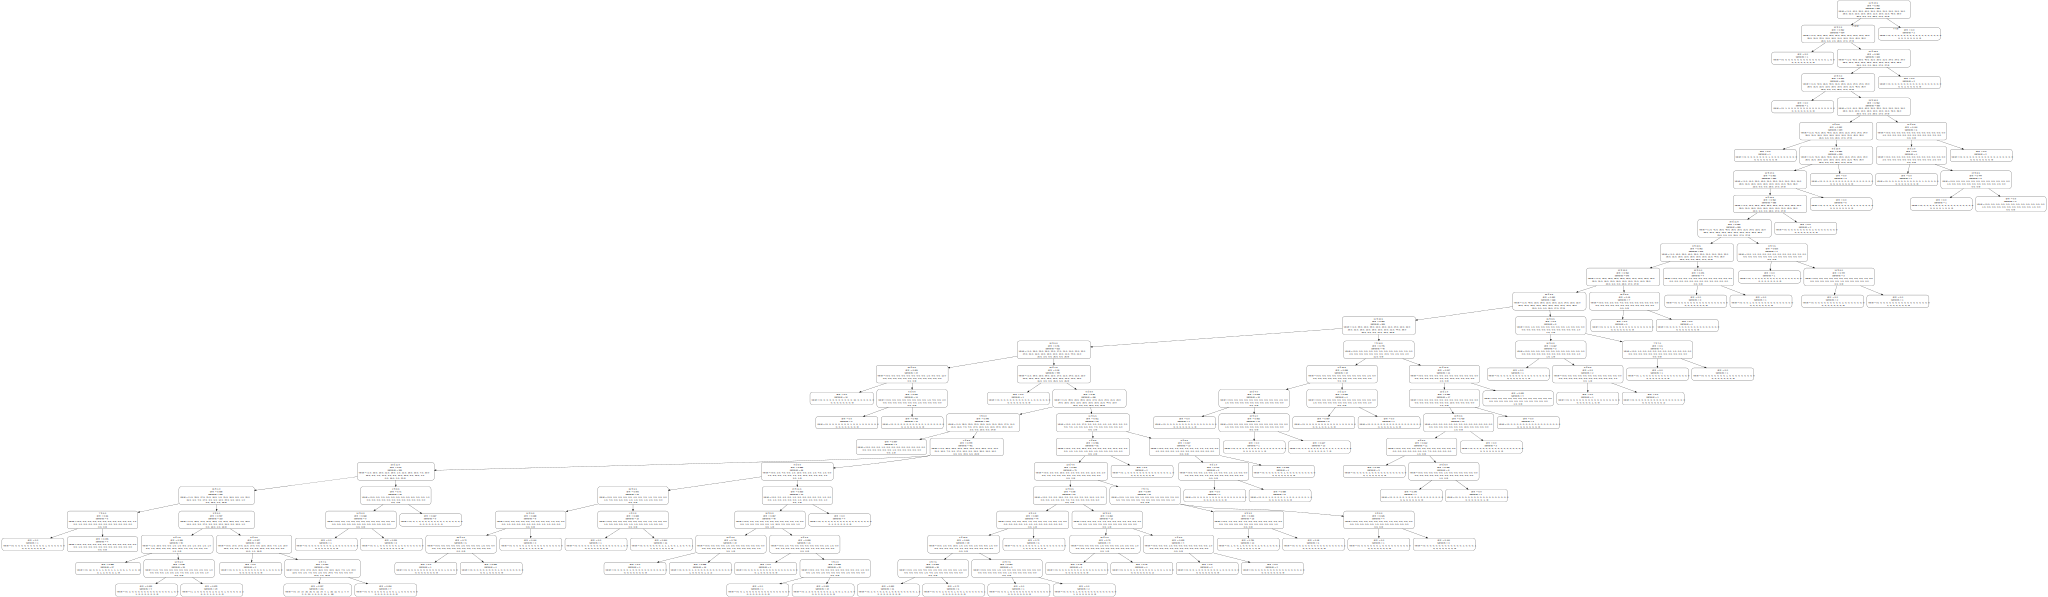

In [789]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X_target_005.columns,  
                         filled=False, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

In [790]:
clf.score(X_target_095,y_target_095)

0.25707096998091272

In [791]:
clf.predict(X_target_095)

array([ 8, 18, 20, ..., 25, 19, 18])